### Final Project: Simulating Concessions at a Stadium

#### State the problem and its significance.
Sport stadiums utilize concessions as a key driver in revenue given the high margins that exist for many of the foods and merchandise that are sold. The challenge with maximizing sales within these venues is that fans tend to visit them when there are breaks in the games which means there is a substantial bottleneck in terms of time when fans may visit. Long wait times are common challenges for fans waiting to get a snack or an alcoholic beverage. Many times guests leave the line due to the long wait times or not wanting to miss more of the main event. There is a massive opportunity as indicated by the survey from [Oracle](https://www.oracle.com/a/ocom/docs/dc/em/fan-experience-report-fb.pdf) that many fans, approximately 36%, blame wait times for harming their experience. They were hoping for improvements in service and wait times to make their experience more enjoyable and make them more likely to purchase these goods. 45% of fans indicated they left a line without making a purchase due to excessive wait times. Therefore, simulating demand and processing is critical for vendors to properly staff and serve their customers.

This analysis will not be exhaustive but will review a few scenarios using probabilistic random distributions of customer and service behavior to see where potential wait times can become excessive and lead to potential missed sales. 

#### Flowchart Diagram|

In [13]:
from IPython.display import Image
Image(url= "flow_diagram.png", width=400, height=400)

#### Simulation
For the first simulation we will test a single intermission duration to evaluation initial functionality of the system; however, we will need to repeat the simulation to get a better sense of potential confidence intervals for expected average times

In [60]:
import seaborn as sns
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
# Parameters
NUM_CASHIERS = 4
ARRIVAL_RATE = 5
GAMMA_SHAPE = 2.0
GAMMA_SCALE = 1.5
SIMULATION_TIME = 30

# Data collection
wait_times = {}
service_times = {}

# Define the fan arrival process
def fan(env, name, concession):
    arrival_time = env.now
    #print(f'{name} arrives at the concession stand at {env.now:.2f}')
    with concession.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times[name] = wait_time
        #print(f'{name} starts being served at {env.now:.2f} (waited {wait_time:.2f} minutes)')
        service_time = np.random.gamma(GAMMA_SHAPE, GAMMA_SCALE)
        service_times[name] = service_time
        yield env.timeout(service_time)
        #print(f'{name} leaves the concession stand at {env.now:.2f}')

# Define the process that generates fans
def fan_generator(env, concession):
    i = 0
    while True:
        yield env.timeout(np.random.exponential(1.0 / ARRIVAL_RATE))
        i += 1
        env.process(fan(env, f'Fan {i}', concession))

In [68]:
env = simpy.Environment()
np.random.seed(49)
concession = simpy.Resource(env, NUM_CASHIERS)
env.process(fan_generator(env, concession))

# Run the simulation
env.run(until=SIMULATION_TIME)

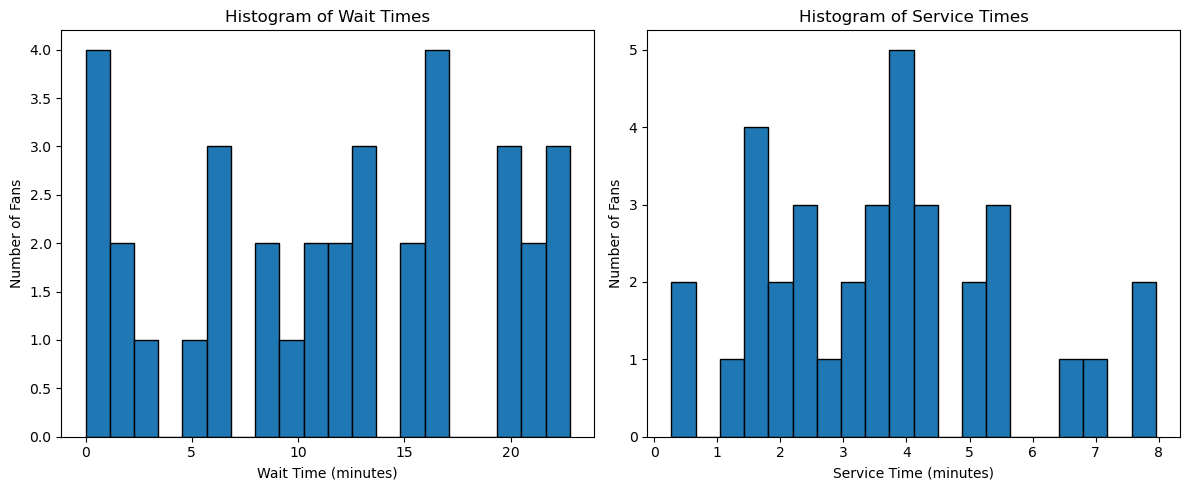

In [69]:

plt.figure(figsize=(12, 5))

# Histogram of wait times
plt.subplot(1, 2, 1)
plt.hist(wait_times.values(), bins=20, edgecolor='black')
plt.title('Histogram of Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Number of Fans')

# Histogram of service times
plt.subplot(1, 2, 2)
plt.hist(service_times.values(), bins=20, edgecolor='black')
plt.title('Histogram of Service Times')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Number of Fans')

plt.tight_layout()
plt.show()

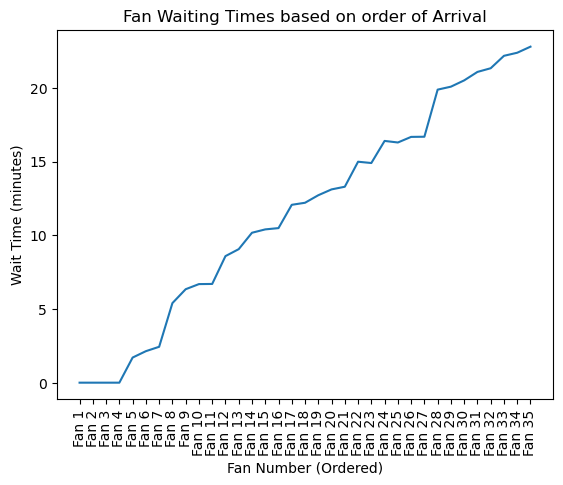

In [70]:
sns.lineplot(x=list(wait_times.keys()),y=wait_times.values()).set_title('Fan Waiting Times based on order of Arrival')
plt.xlabel('Fan Number (Ordered)')
plt.ylabel('Wait Time (minutes)')
plt.xticks(rotation=90)
plt.show();

The simplest version of this simulation probably does not represent reality as the spacing between fan arrival is not specified and it considers fan wait time to be unlimited. In reality there is a true upper limit on the length of time a fan is willing to wait before departing the concession and this version of the simulation would in theory continue to allow for unreasonably long wait times

In [71]:
env = simpy.Environment()
np.random.seed(42)
concession = simpy.Resource(env, NUM_CASHIERS)
env.process(fan_generator(env, concession))
SIMULATION_TIME = 120
env.run(until=SIMULATION_TIME)

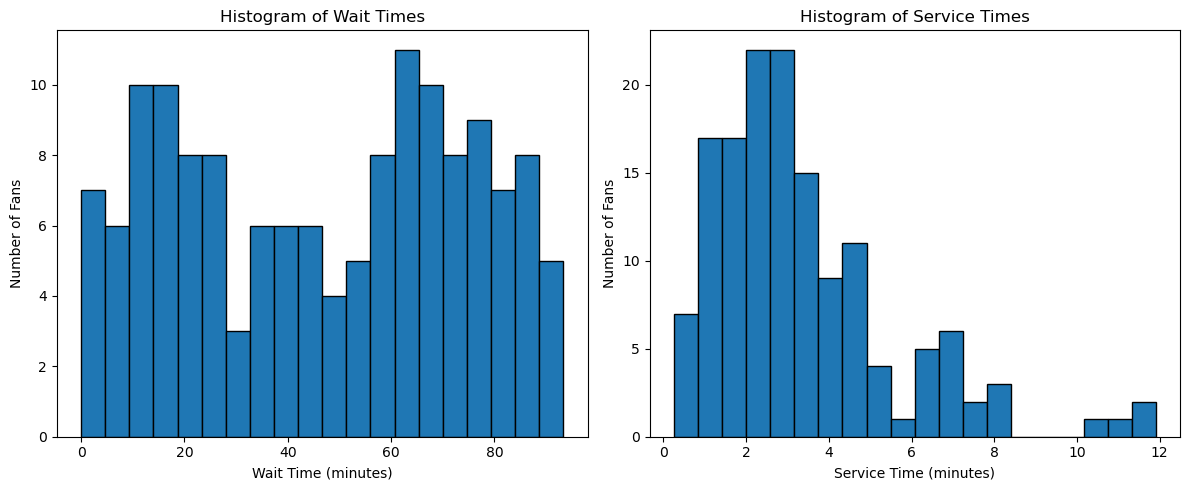

In [72]:
plt.figure(figsize=(12, 5))

# Histogram of wait times
plt.subplot(1, 2, 1)
plt.hist(wait_times.values(), bins=20, edgecolor='black')
plt.title('Histogram of Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Number of Fans')

# Histogram of service times
plt.subplot(1, 2, 2)
plt.hist(service_times.values(), bins=20, edgecolor='black')
plt.title('Histogram of Service Times')
plt.xlabel('Service Time (minutes)')
plt.ylabel('Number of Fans')

plt.tight_layout()
plt.show()

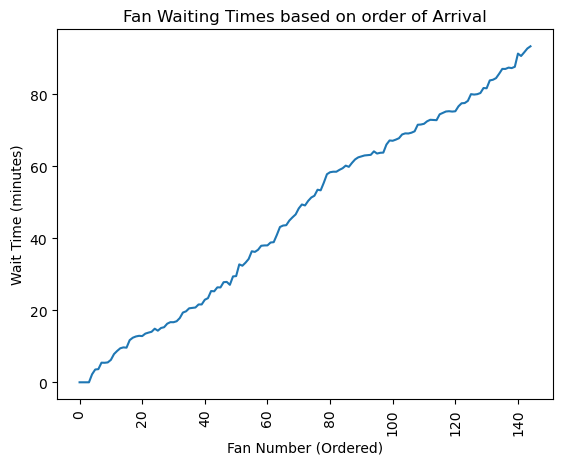

In [73]:
sns.lineplot(x=range(0,len(wait_times)),y=wait_times.values()).set_title('Fan Waiting Times based on order of Arrival')
plt.xlabel('Fan Number (Ordered)')
plt.ylabel('Wait Time (minutes)')
plt.xticks(rotation=90)
plt.show();

As expected, this designed simulation is invalid given that it only accounts for an unlimited top end range for customers to wait for food. No fan would likely wait 80+ minutes given the duration of many of these events.

#### Modifying Process

Let's incorporate a maximum waiting time to account for limited patience and unwillingness to miss much event time

In [74]:
from IPython.display import Image
Image(url= "flow_diagram2.png", width=400, height=400)

In [75]:
NUM_CASHIERS = 3                   # Number of cashiers at the concession stand
INTERARRIVAL_RATE = 5              # Average number of fans arriving per minute
GAMMA_SHAPE = 2.0                  # Shape parameter for the gamma distribution
GAMMA_SCALE = 1.5                  # Scale parameter for the gamma distribution (mean service time = shape * scale)
SIMULATION_TIME = 45               # Total simulation time (minutes)
MAX_WAIT_TIME = 30                 # Maximum wait time before a fan leaves (minutes)
NUM_SIMULATIONS = 100              # Number of simulations to run

def run_simulation(env, concession, wait_times, arrival_positions, abandoned_count):
    i = 0
    while env.now < SIMULATION_TIME:
        interarrival_time = np.random.exponential(1.0 / INTERARRIVAL_RATE)
        yield env.timeout(interarrival_time)
        i += 1
        arrival_position = i
        env.process(fan(env, f'Fan {i}', concession, wait_times, arrival_position, arrival_positions, abandoned_count))

def fan(env, name, concession, wait_times, arrival_position, arrival_positions, abandoned_count):
    arrival_time = env.now
    #print(f'{name} arrives at the concession stand at {env.now:.2f}')
    with concession.request() as request:
        results = yield request | env.timeout(MAX_WAIT_TIME)
        if request in results:
            wait_time = env.now - arrival_time
            wait_times.append(wait_time)
            arrival_positions.append(arrival_position)
            #print(f'{name} starts being served at {env.now:.2f} (waited {wait_time:.2f} minutes)')
            service_time = np.random.gamma(GAMMA_SHAPE, GAMMA_SCALE)
            yield env.timeout(service_time)
            #print(f'{name} leaves the concession stand at {env.now:.2f}')
        else:
            # Fan leaves the line after waiting too long
            abandoned_count[0] += 1
            #print(f'{name} leaves the line after waiting more than {MAX_WAIT_TIME} minutes at {env.now:.2f}')

In [76]:
all_wait_times = []
all_arrival_positions = []
total_abandoned = []
np.random.seed(48)
for _ in range(NUM_SIMULATIONS):
    env = simpy.Environment()
    concession = simpy.Resource(env, NUM_CASHIERS)
    wait_times = []
    arrival_positions = []
    abandoned_count = [0]
    env.process(run_simulation(env, concession, wait_times, arrival_positions, abandoned_count))
    env.run(until=SIMULATION_TIME)
    all_wait_times.extend(wait_times)
    all_arrival_positions.extend(arrival_positions)
    total_abandoned.append(abandoned_count[0])

all_wait_times = np.array(all_wait_times)
all_arrival_positions = np.array(all_arrival_positions)

max_arrival_position = np.max(all_arrival_positions)
average_wait_times = []

for position in range(1, max_arrival_position + 1):
    mask = all_arrival_positions == position
    if np.any(mask):
        avg_wait_time = np.mean(all_wait_times[mask])
        average_wait_times.append(avg_wait_time)
    else:
        average_wait_times.append(np.nan)  # No data for this position

# Calculate the average number of fans abandoning the line
average_abandoned = np.mean(total_abandoned)

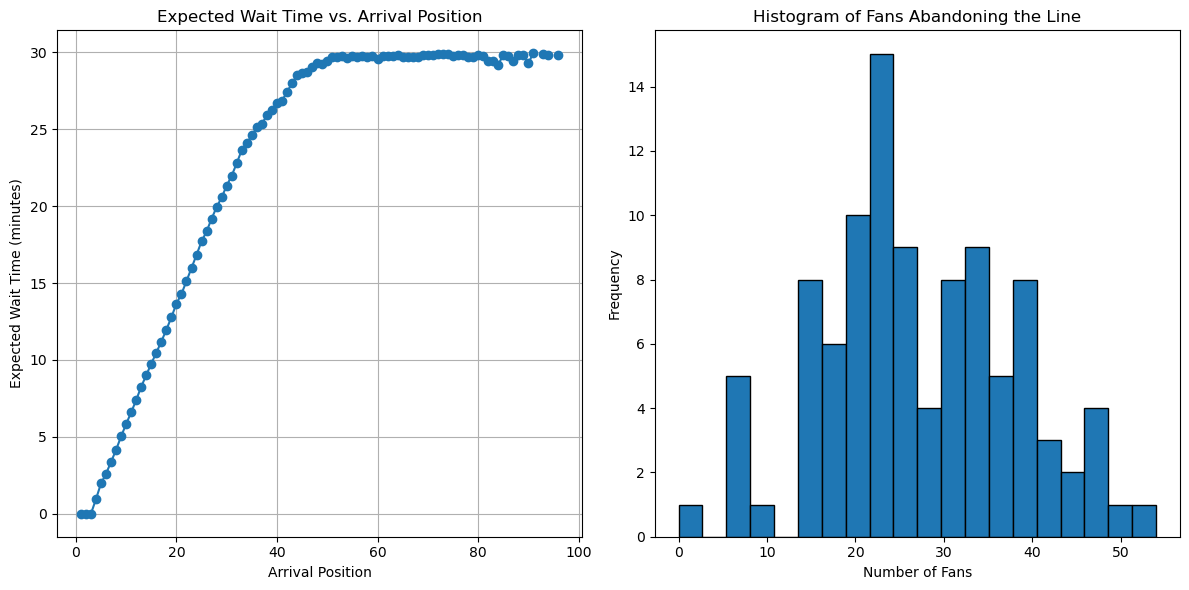

Average number of fans abandoning the line per simulation: 27.19
Average number of fan wait time across all of the simulations: 16.30


In [77]:
# Plot the response surface curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_arrival_position + 1), average_wait_times, marker='o', linestyle='-')
plt.title('Expected Wait Time vs. Arrival Position')
plt.xlabel('Arrival Position')
plt.ylabel('Expected Wait Time (minutes)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(total_abandoned, bins=20, edgecolor='black')
plt.title('Histogram of Fans Abandoning the Line')
plt.xlabel('Number of Fans')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Average number of fans abandoning the line per simulation: {average_abandoned:.2f}")
print(f"Average number of fan wait time across all of the simulations: {np.mean(all_wait_times):.2f}")

By setting a maximum wait time of 30 minutes the simulations start to identify some likely loss of patience which causes customers to leave. The response curve also shows a fairly large spike in the number of customers wait times as more fans arrive during limited windows. The earlier that you get to the concession stand the more likely it is to reduce the amount of time waiting.

Let's try to see what the differences are when incorporating more servers available to handle the orders.

In [78]:
server_amt_wait_times = {}
server_amt_abandoned = {}
server_amt_max_arrivals = {}
for cashiers in range(4,10):
    all_wait_times = []
    all_arrival_positions = []
    total_abandoned = []
    np.random.seed(48)
    for _ in range(NUM_SIMULATIONS):
        env = simpy.Environment()
        concession = simpy.Resource(env, cashiers)
        wait_times = []
        arrival_positions = []
        abandoned_count = [0]
        env.process(run_simulation(env, concession, wait_times, arrival_positions, abandoned_count))
        env.run(until=SIMULATION_TIME)
        all_wait_times.extend(wait_times)
        all_arrival_positions.extend(arrival_positions)
        total_abandoned.append(abandoned_count[0])
    
    all_wait_times = np.array(all_wait_times)
    all_arrival_positions = np.array(all_arrival_positions)
    
    max_arrival_position = np.max(all_arrival_positions)
    average_wait_times = []
    
    for position in range(1, max_arrival_position + 1):
        mask = all_arrival_positions == position
        if np.any(mask):
            avg_wait_time = np.mean(all_wait_times[mask])
            average_wait_times.append(avg_wait_time)
        else:
            average_wait_times.append(np.nan)  # No data for this position
    server_amt_wait_times[cashiers] = average_wait_times
    server_amt_abandoned[cashiers] = total_abandoned
    server_amt_max_arrivals[cashiers] = max_arrival_position
    average_abandoned = np.mean(total_abandoned)

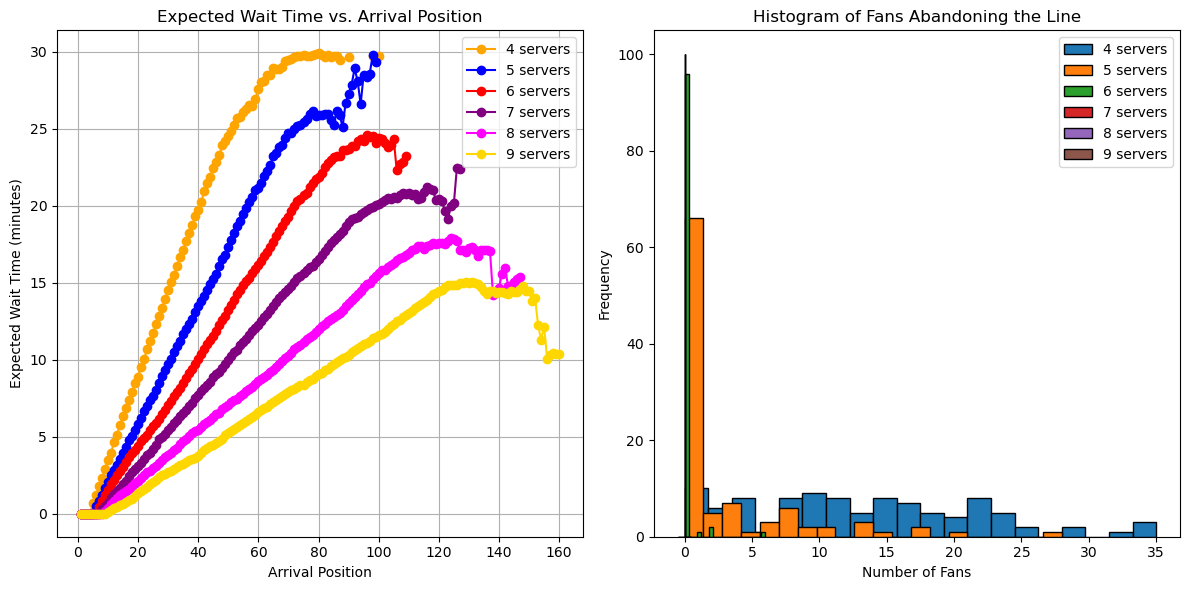

In [79]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2,1)
plt.plot(range(1, server_amt_max_arrivals[4] + 1), server_amt_wait_times[4], marker='o', linestyle='-',color='orange')
plt.plot(range(1, server_amt_max_arrivals[5] + 1), server_amt_wait_times[5], marker='o', linestyle='-',color='blue')
plt.plot(range(1, server_amt_max_arrivals[6] + 1), server_amt_wait_times[6], marker='o', linestyle='-',color='red')
plt.plot(range(1, server_amt_max_arrivals[7] + 1), server_amt_wait_times[7], marker='o', linestyle='-',color='purple')
plt.plot(range(1, server_amt_max_arrivals[8] + 1), server_amt_wait_times[8], marker='o', linestyle='-',color='magenta')
plt.plot(range(1, server_amt_max_arrivals[9] + 1), server_amt_wait_times[9], marker='o', linestyle='-',color='gold')
plt.legend(labels=['4 servers','5 servers','6 servers','7 servers','8 servers','9 servers'])
plt.title('Expected Wait Time vs. Arrival Position')
plt.xlabel('Arrival Position')
plt.ylabel('Expected Wait Time (minutes)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(server_amt_abandoned[4], bins=20, edgecolor='black')
plt.hist(server_amt_abandoned[5], bins=20, edgecolor='black')
plt.hist(server_amt_abandoned[6], bins=20, edgecolor='black')
plt.hist(server_amt_abandoned[7], bins=20, edgecolor='black')
plt.hist(server_amt_abandoned[8], bins=20, edgecolor='black')
plt.hist(server_amt_abandoned[9], bins=20, edgecolor='black')
plt.title('Histogram of Fans Abandoning the Line')
plt.legend(labels=['4 servers','5 servers','6 servers','7 servers','8 servers','9 servers'])
plt.xlabel('Number of Fans')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [80]:
pd.DataFrame(server_amt_abandoned).melt(var_name='Number_of_Servers').groupby('Number_of_Servers')['value'].describe()

,count,mean,std,min,25%,50%,75%,max
Number_of_Servers,,,,,,,,
4,100.0,13.05,8.612154,0.0,6.75,12.5,19.25,35.0
5,100.0,2.80,5.179603,0.0,0.00,0.0,4.00,28.0
6,100.0,0.11,0.665074,0.0,0.00,0.0,0.00,6.0
7,100.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
8,100.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0
9,100.0,0.00,0.000000,0.0,0.00,0.0,0.00,0.0


#### Validation/Verification

This model would indicate that with 7 or more servers there aren't any abandoned customers; however, it seems a bit unlikely to be the case based on other publications and surveys. There is clearly benefit to adding more servers although perhaps based on the type of items served the optimal number may vary to reflect each location's realistic demand. The above code blocks goes through the process of validation to test the assumptions of the model and keep adding potential nuances to mirror the complexity of the real process. Based on review of available data and discussion from the professor the distributions appear to be somewhat reasonable assumptions to try to simulate the queueing process. There are a number of other means of improving operational efficiency although it can be quite challenging to get access to real data to formally verify the model. Therefore, reading through other publications as well as publicly avaiable research on these topics helped to verify the assumptions.

#### Conclusion

It wasn't as challenging to build randomness and complexity into a model and the iterative nature of this final project allowed me to test new enhancements to evaluate the factors that exist in real life operations of any service business. The evaluations are probably somewhat limited in that different events have various breaks in action that allow fans to take a break and get a refreshment. Therefore, more research would need to be done to potentially account for these different layers of variability that would impact required staffing to adequately meet needs. It might make sense to narrow the scope to a specific type of sports event that has similar break patterns that would allow for a consistent queueing process to be simulated. Patience is a virtue and it is likely that different fans have alternative expectations of their maximum wait times which could be explored further. Other research has pointed to splitting lines, creating express lanes, and mobile food servers to try to meet more customers where they are and these areas could be explored further in future review.

#### Sources

* https://www.oracle.com/a/ocom/docs/dc/em/fan-experience-report-fb.pdf
* https://etd.auburn.edu/bitstream/handle/10415/6956/Thesis_Mengdie%20Chen_2019.pdf?isAllowed=y&sequence=2
* https://seatserve.com/blog/stadium-concessions-challenge-solution/
* https://www.math.unl.edu/~gledder1/Notes/428/Queueing%20Theory%20Notes.pdf
* https://marketscale.com/industries/sports-and-entertainment/sports-fans-enjoy-concessions-but-not-the-wait-how-might-crowd-intelligence-solutions-change-this/